In [125]:
# Youtube: https://www.youtube.com/watch?v=NJNvXEYa_gM

In [26]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from config import *

In [27]:
# CONSTANTS!!!

# STEP 1 - Load and visualize data
dataInputPath = DATA_PATH + '/train/'
imagePathInput = os.path.join(dataInputPath, 'image/image')
maskPathInput = os.path.join(dataInputPath, 'mask/mask')

dataOutputPath = DATA_PATH + '/sliced-output/train/'
imageSliceOutput = os.path.join(dataOutputPath, 'image/image')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/mask')

dataInputTestPath = DATA_PATH + '/test/'
imagePathTestInput = os.path.join(dataInputTestPath, 'image/image')
maskPathTestInput = os.path.join(dataInputTestPath, 'mask/mask')

dataOutputTestPath = DATA_PATH + '/sliced-output/test/'
imageSliceTestOutput = os.path.join(dataOutputTestPath, 'image/image')
maskSliceTestOutput = os.path.join(dataOutputTestPath, 'mask/mask')

# STEP 2 - Image normalization
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# STEP 3 - Slicing and saving
SLICE_X = True
SLICE_Y = True
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [28]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(imagePathInput, '1.2.80.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-933.0, 2070.0, (45, 45, 90), numpy.memmap)

In [29]:
# Load image mask and see max min Hounsfield units
maskPath = os.path.join(maskPathInput, '1.2.80.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (45, 45, 90), numpy.memmap)

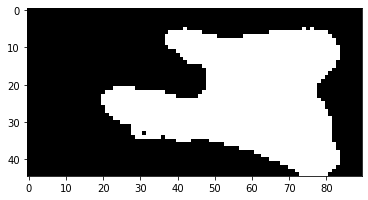

In [30]:
# Show image slice
imgSlice = mask[30,:,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [31]:
# Normalize image

def normalizeImageIntensityRange(img):
    
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.022333333333333334, 1.0, (45, 45, 90), numpy.ndarray)

In [32]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [33]:
# Save volume slice to file

def saveSlice(img, fname, path):
    img = np.uint8(img * 255)

    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
#saveSlice(nImg[40,:,:], 'test', imageSliceOutput)
#saveSlice(mask[40,:,:], 'test', maskSliceOutput)

In [42]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [43]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'/*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/export/skulls/projects/teeth/data/u-net-data/train/image/image/1.2.80.nii (45, 45, 90) 180 0.022333333333333334 1.0
45 45 90
Slicing X: 
Slicing Y: 


Slicing Z: 
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth0-slice089_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/1.2.80.nii, 180 slices created 



/export/skulls/projects/teeth/data/u-net-data/train/image/image/16.2.73.nii (70, 64, 109) 243 0.0 1.0
70 64 109
Slicing X: 
Slicing Y: 


Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth1-slice108_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/16.2.73.nii, 243 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/image/image/25.9.80.nii (77, 84, 105) 266 0.19433333333333333 1.0
77 84 105
Slicing X: 


Slicing Y: 


Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth2-slice104_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/25.9.80.nii, 266 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/image/image/29.4.78.nii (77, 65, 101) 243 0.07866666666666666 1.0
77 65 101
Slicing X: 


Slicing Y: 
Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth3-slice100_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/29.4.78.nii, 243 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/image/image/6.12.93.nii (74, 67, 96) 237 0.08766666666666667 1.0
74 67 96
Slicing X: 


Slicing Y: 
Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth4-slice095_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/6.12.93.nii, 237 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/image/image/9.1.81.nii (77, 69, 96) 242 0.13533333333333333 0.9436666666666667
77 69 96
Slicing X: 


Slicing Y: 


Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth5-slice095_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/9.1.81.nii, 242 slices created 



/export/skulls/projects/teeth/data/u-net-data/train/image/image/9.10.90.nii (54, 61, 90) 205 0.17933333333333334 1.0
54 61 90
Slicing X: 
Slicing Y: 


Slicing Z: 


[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/image/image/tooth6-slice089_z.png
/export/skulls/projects/teeth/data/u-net-data/train/image/image/9.10.90.nii, 205 slices created 



In [44]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'/*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/export/skulls/projects/teeth/data/u-net-data/train/mask/mask/1.2.80.nii (45, 45, 90) 180 0.0 1.0
45 45 90
Slicing X: 
Slicing Y: 


Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/mask/mask/tooth0-slice044_y.png
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/mask/mask/tooth0-slice089_z.png
/export/skulls/projects/teeth/data/u-net-data/train/mask/mask/1.2.80.nii, 180 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/mask/mask/16.2.73.nii (70, 64, 109) 243 0.0 1.0
70 64 109
Slicing X: 
Slicing Y: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/mask/mask/tooth1-slice069_x.png
Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/mask/mask/tooth1-slice063_y.png
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/train/mask/mask/tooth1-slice108_z.png
/export/skulls/projects/teeth/data/u-net-data/train/mask/mask/16.2.73.nii, 243 slices created 

/export/skulls/projects/teeth/data/u-net-data/train/mask/mask/25.9.80.nii (77, 84, 105) 266 0.0 1.0
77 84 105
Sl

In [47]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathTestInput+'/*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), imageSliceTestOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/export/skulls/projects/teeth/data/u-net-data/test/image/image/14.8.93.nii (49, 52, 85) 186 0.3333333333333333 0.8503333333333334
49 52 85
Slicing X: 
Slicing Y: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/image/image/tooth0-slice048_x.png
Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/image/image/tooth0-slice051_y.png
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/image/image/tooth0-slice084_z.png
/export/skulls/projects/teeth/data/u-net-data/test/image/image/14.8.93.nii, 186 slices created 

/export/skulls/projects/teeth/data/u-net-data/test/image/image/29.11.92.nii (82, 60, 94) 236 0.11166666666666666 1.0
82 60 94
Slicing X: 
Slicing Y: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/image/image/tooth1-slice081_x.png
Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/image/image/tooth1-slice059_y.png
[+] Slice saved: /export/skulls/pr

In [48]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathTestInput+'/*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'tooth'+str(index), maskSliceTestOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/export/skulls/projects/teeth/data/u-net-data/test/mask/mask/14.8.93.nii (49, 52, 85) 186 0.0 1.0
49 52 85
Slicing X: 
Slicing Y: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/tooth0-slice048_x.png
Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/tooth0-slice051_y.png
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/tooth0-slice084_z.png
/export/skulls/projects/teeth/data/u-net-data/test/mask/mask/14.8.93.nii, 186 slices created 

/export/skulls/projects/teeth/data/u-net-data/test/mask/mask/29.11.92.nii (82, 60, 94) 236 0.0 1.0
82 60 94
Slicing X: 
Slicing Y: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/tooth1-slice081_x.png
Slicing Z: aved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/tooth1-slice059_y.png
[+] Slice saved: /export/skulls/projects/teeth/data/u-net-data/sliced-output/test/mask/mask/toot